## Classification with an autoencoder

In this notebook we're going to train an autoencoder to create an embedding for our images. This embeddings can be augmented with the processed metadata to obtain our input for classification

<a href="https://githubtocolab.com/corgi-vision/skin-cancer-detection/blob/main/explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
from preprocessing import download_data

# Download the dataset if needed
download_data()

In [ ]:
import tensorflow as tf

# GPU setup for shared server - NO NEED TO RUN IN COLAB
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Found GPU {gpu.name}, and set memory growth to True")

2024-11-17 23:39:12.062147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731883155.205229 1127666 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731883155.758714 1127666 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found GPU /physical_device:GPU:0, and set memory growth to True


## Loading the dataset

Loading the metadata and creating a train-test-validation split. The utility methods from the `preprocessing` module are used to create a dataset the yields (image, image) tuples

In [3]:
from preprocessing import create_reconstruction_dataset, load_metadata, upsample_metadata
from sklearn.model_selection import train_test_split
import pandas as pd


pd.options.mode.copy_on_write = True

# Load the metadata and create train, test and validation split
metadata = load_metadata()
metadata = upsample_metadata(metadata, upsample_factor=5)
metadata_train, metadata_test = train_test_split(metadata, test_size=0.3)
metadata_test, metadata_valid = train_test_split(metadata_test, test_size=0.4)

# Load the dataset generators
batch_size=32
ds_train = create_reconstruction_dataset(metadata_train, batch_size)
ds_test = create_reconstruction_dataset(metadata_test, batch_size)
ds_valid = create_reconstruction_dataset(metadata_valid, batch_size)

c:\BME\season_07\deep_learning\skin-cancer-detection\preprocessing.py:113: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(METADATA_PATH, dtype={"target": "int8", "age_approx": "Int8"})


In [115]:
# Construct the input shape from the size of the images
# and the number of channels (RGB)

input_shape = (*ds_train[0][0].shape[1:3], 3)
input_shape

(133, 133, 3)

In [6]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Cropping2D #, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class Autoencoder(Model):
    """Autoencoder to create an embedding for the images"""

    def __init__(self, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.encoder = Sequential([
            Input((133,133,3)),
            Conv2D(32, 5, activation="relu", padding="same", strides=2),
            Conv2D(16, 3, activation="relu", padding="same", strides=2),
            Conv2D(1, 3, activation="relu", padding="same", strides=2),
        ])
        self.decoder = Sequential([
            Conv2DTranspose(8, 3, strides=2, padding="same", activation="relu"),
            Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
            Conv2DTranspose(32, 5, strides=2, padding="same", activation="relu"),
            Conv2D(3, 3, activation="sigmoid", padding="same"),
            Cropping2D(((2,1), (2,1)))
        ])
    
    def get_config(self):
        super().get_config()

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder()
model.compile(optimizer="adam", loss="mean_absolute_error", metrics=["mean_squared_error"])
model.encoder.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 67, 67, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 34, 34, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 17, 17, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,201 (28.13 KB)

 Trainable params: 7,201 (28.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import wandb

# This block runs the training. No need to execute for review purpuses, since the trained model is loaded below

run = wandb.init(project="skin-cancer-detection")

callbacks = [
    EarlyStopping(patience=20, start_from_epoch=20, restore_best_weights=True),
    ModelCheckpoint("autoencoder.keras", save_best_only=True),
    wandb.keras.WandbMetricsLogger(),
    wandb.keras.WandbModelCheckpoint("autoencoder.keras", save_best_only=True)
]

model.fit(ds_train, batch_size=batch_size, epochs=150, validation_data=ds_valid, callbacks=callbacks)

run.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: csonto-benjamin (corgi-vision). Use `wandb login --relogin` to force relogin


Epoch 1/300
7812/8817 ━━━━━━━━━━━━━━━━━━━━ 2:33 153ms/step - loss: 0.0149

2024-11-17 21:02:07.104284: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[4,1,136,136]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,136,136]{3,2,1,0}, f32[1,64,3,3]{3,2,1,0}, f32[1]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


8817/8817 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0149

2024-11-17 21:11:42.096763: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[12,1,136,136]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,64,136,136]{3,2,1,0}, f32[1,64,3,3]{3,2,1,0}, f32[1]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


8817/8817 ━━━━━━━━━━━━━━━━━━━━ 1775s 201ms/step - loss: 0.0149 - val_loss: 0.0150
Epoch 2/300
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 941s 107ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 3/300
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 1150s 130ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 4/300
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 656s 74ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 5/300
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 1018s 115ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 6/300
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 1271s 144ms/step - loss: 0.0149 - val_loss: 0.0148
Epoch 7/300
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 1272s 144ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 8/300
8817/8817 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0148

## Download and evaluate the trained model

In [ ]:
import wandb
from pathlib import Path
from tensorflow.keras.models import load_model


def download_artifact(local_registry_path: str):
    api = wandb.Api()
    artifact = api.artifact('corgi-vision/skin-cancer-detection/run_1qyil3j5_model:v7', type='model')
    return artifact.download(local_registry_path)


local_registry_path = "local_model_registry"
# download_artifact(local_registry_path)
model = load_model(Path(local_registry_path) / "autoencoder.keras", custom_objects={"Autoencoder": Autoencoder})
model.evaluate(ds_test)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


2267/2267 ━━━━━━━━━━━━━━━━━━━━ 13:31:32 21s/step - loss: 0.0232 - mean_squared_error: 9.5031e- ━━━━━━━━━━━━━━━━━━━━ 3:48 101ms/step - loss: 0.0232 - mean_squared_error: 9.6340e-04 ━━━━━━━━━━━━━━━━━━━━ 3:58 105ms/step - loss: 0.0235 - mean_squared_error: 9.9209e- ━━━━━━━━━━━━━━━━━━━━ 3:57 105ms/step - loss: 0.0237 - mean_squared_error: 0.0010   ━━━━━━━━━━━━━━━━━━━━ 3:58 106ms/step - loss: 0.0237 - mean_squared_error: 0.00 ━━━━━━━━━━━━━━━━━━━━ 3:57 105ms/step - loss: 0.0238 - mean_squared_error: 0.00 ━━━━━━━━━━━━━━━━━━━━ 3:55 104ms/step - loss: 0.0238 - mean_squared_error: 0.00 ━━━━━━━━━━━━━━━━━━━━ 3:55 104ms/step - loss: 0.0238 - mean_squared_error: 0.00 ━━━━━━━━━━━━━━━━━━━━ 3:53 104ms/step - loss: 0.0238 - mean_squared_error: 0.00 ━━━━━━━━━━━━━━━━━━━━ 3:52 103ms/step - loss: 0.0238 - mean_squared_error: 0.00 ━━━━━━━━━━━━━━━━━━━━ 3:52 103ms/step - loss: 0.0238 - mean_squared_error: 0.00 ━━━━━━━━━━━━━━━━━━━━ 3:53 103ms/step - loss: 0.0238 - mean_squared_error: 0.00 ━━━━━━━━━━━━━━━━━━━━ 3

[0.02350478805601597, 0.0010591729078441858]

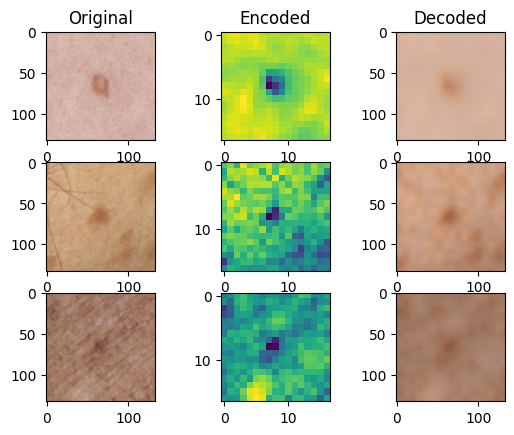

In [128]:
import matplotlib.pyplot as plt

samples = ds_test[0][0][:3]
encoded = model.encoder(samples)
decoded = model.decoder(encoded)

fig, ax = plt.subplots(3, 3)
ax[0][0].set_title("Original")
ax[0][1].set_title("Encoded")
ax[0][2].set_title("Decoded")

for i in range(len(samples)):
    ax[i][0].imshow(samples[i])
    ax[i][1].imshow(encoded[i])
    ax[i][2].imshow(decoded[i])

## Classification using the embedding

In the following stage, we are going to use the autoencoder we've just trained and concatenate our metadata. <br>
The `create_encoded_dataset()` helper function returns a `SkinCancerEncodedDataset` that handles this encoding.
With this we can train a model for classification with both our images and the addition information in the .csv files.

First, let's recreate our datasets with the new dataset generator

In [1]:
from preprocessing import create_encoded_dataset
import pandas as pd
import wandb
from preprocessing import load_metadata, upsample_metadata
from sklearn.model_selection import train_test_split

pd.options.mode.copy_on_write = True

api = wandb.Api()
artifact = api.artifact('corgi-vision/skin-cancer-detection/run_1qyil3j5_model:v10', type='model')
encoder = {
    "name": "autoencoder.keras",
    "artifact": artifact  
}

# Load the metadata and create train, test and validation split
metadata = load_metadata()
metadata = upsample_metadata(metadata, upsample_factor=5)
metadata_train, metadata_test = train_test_split(metadata, test_size=0.3)
metadata_test, metadata_valid = train_test_split(metadata_test, test_size=0.4)

# Load the dataset generators
batch_size=32
ds_train = create_encoded_dataset(metadata_train, encoder, batch_size)
ds_test = create_encoded_dataset(metadata_test, encoder, batch_size)
ds_valid = create_encoded_dataset(metadata_valid, encoder, batch_size)


c:\BME\season_07\deep_learning\skin-cancer-detection\preprocessing.py:120: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(METADATA_PATH, dtype={"target": "int8", "age_approx": "Int8"})


In [2]:
input_shape = ds_train[0][0].shape[1]
input_shape

324

For the model, we are going to train a fully connected architecture with skip connections,
to mitigate the gradient problems.

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import Input
from tensorflow.keras import optimizers
import keras_tuner as kt


def create_model(hp: kt.HyperParameters):
    n1 = hp.Int("layer1_units", min_value=16, max_value=64, step=16)
    n2 = hp.Int("layer2_units", min_value=32, max_value=128, step=32)
    opt_type = hp.Choice("optimizer_type", values=["sgd", "adam"])
    lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    inputs = Input((input_shape,))
    x1 = Dense(n1, "relu")(inputs)
    x1 = Dense(n2)(x1)
    skip_connection = Dense(n2)(inputs)
    x2 = Activation("relu")(x1 + skip_connection)
    x2 = Dense(n1, "relu")(x2)
    outputs = Dense(1, "sigmoid")(x2)

    optimizer = optimizers.get({"class_name":opt_type, "config": {"learning_rate": lr}})
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer, "binary_crossentropy", metrics=["binary_accuracy"])
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

tuner = kt.Hyperband(create_model,
             objective="val_accuracy",
             max_epochs=10,
             directory="local_model_registry",
             project_name="encoded_residual_kt")

tuner.search(ds_train, epochs=50, validation_data=ds_valid, callbacks=[EarlyStopping(patience=5)])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |64                |layer1_units
64                |64                |layer2_units
sgd               |sgd               |optimizer_type
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 120/8817 ━━━━━━━━━━━━━━━━━━━━ 10:56 75ms/step - binary_accuracy: 0.5107 - loss: 1.2367

KeyboardInterrupt: 

In [4]:
history = model.fit(ds_train, epochs=2, batch_size=batch_size, validation_data=ds_valid)

Epoch 1/2
6960/8817 ━━━━━━━━━━━━━━━━━━━━ 1:26 47ms/step - binary_accuracy: 0.6725 - loss: 0.7383

KeyboardInterrupt: 

In [10]:
model.evaluate(ds_test)

2267/2267 ━━━━━━━━━━━━━━━━━━━━ 175s 77ms/step - accuracy: 0.9946 - loss: 0.0294


[0.029795700684189796, 0.9945412278175354]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


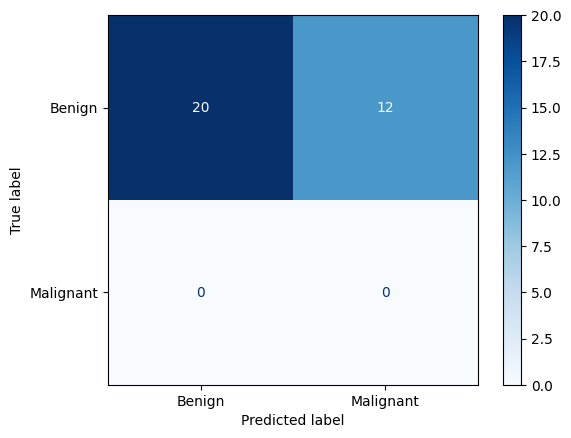

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


predictions = np.round(model.predict(ds_valid[0][0]), 0)
labels = ds_valid.labels[:32]

cm = confusion_matrix(labels, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

display.plot(cmap=plt.cm.Blues)
